In [1]:
#!/usr/bin/python
import nltk
import numpy as np
import re
import tensorflow as tf
from nltk.tokenize import WordPunctTokenizer
from random import randint
from sklearn.model_selection import train_test_split
import random

Importing Glove and  40000 words list 

In [2]:
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')
print(len(wordsList))
print(wordVectors.shape)
print(wordsList[5066])
print(wordVectors[5066][:])

Loaded the word list!
Loaded the word vectors!
400000
(400000, 50)
closure
[ 0.50653   0.12284  -0.11653  -0.21052  -1.0672   -0.17536   0.16253
  0.76781   0.25517  -0.15995   0.025424 -0.65425  -0.44638  -0.19395
  0.45319   1.0955    0.050096 -0.36712   0.1729    0.28393   0.85448
 -0.54932  -1.1816    0.066158 -0.58561  -0.84893   0.1947    0.37832
  0.94141   0.62982   2.3869   -0.41035  -0.11599   0.049907 -0.41563
 -0.056999  1.5044   -0.93772  -0.16045   0.80019  -0.44448  -0.50036
  0.065875  0.27778  -0.27505  -0.012317 -0.37458   0.49171  -0.35498
  0.035347]


Importing the Dataset 

In [47]:
#--------------------Extracting Emotion && sentences from corpus
def extract(dataset):
    f = open(dataset, 'r+')
    linea = f.readline()
    emotion = []
    sentences = []
    while linea != "":    
        linea = linea.split("#")
        #print(linea)
        #Obtaining the emocion
        emotion.append(linea[1])
        sentences.append(linea[2])
        linea = f.readline()
    f.close()
    return sentences,emotion

dataset = "Tales_Dataset/TaleHighEmotion.txt"
sentences,emotion = extract(dataset)
print(emotion[0]," ",sentences[0])
print("Labels: ",len(emotion), "Sentences: ",len(sentences))

3   "It is very unpleasant, I am afraid of the police," said Pickles.

Labels:  1207 Sentences:  1207


Reformating Emotion to Integer Representation :Antes {2=Angry-Disgusted, 3=Fearful, 4=Happy, 6=Sad, 7=Surprised} Ahora: 
 {hp = 1, sd = 2, ag = 3, dg = 4, sp = 5, fr = 6}

In [48]:
def toClasses(emo):
    id_emo = []
    for e in emo:
        if e == '2':
            e = 3
        elif e == '3':
            e = 6
        elif e == '4':
            e = 1
        elif e == '6':
            e = 2
        elif e == '7':
            e = 5          
        id_emo.append(e)
    return id_emo

emotion = toClasses(emotion)
print(emotion[0]," ",sentences[0])

6   "It is very unpleasant, I am afraid of the police," said Pickles.



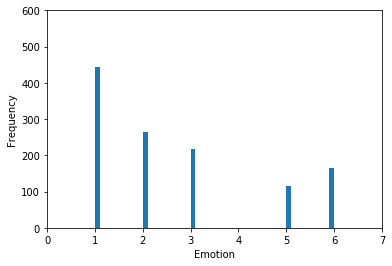

In [49]:
import matplotlib.pyplot as plt
import collections
%matplotlib inline
def histograma(emotion):
    #print(emotion)
    plt.hist(emotion, 50)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.axis([0, 7, 0, 600])
    plt.show()
histograma(emotion)

Preprocesing of Sentences

In [50]:
def decontracted(phrase):
    # specific
    '''phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)'''

    if phrase == "t":
        phrase = "not"
    elif phrase == "re":
        phrase = "are"
    elif phrase == "s":
        phrase = "is"
    elif phrase == "d":
        phrase = "would"
    elif phrase == "ve":
        phrase = "have"
    elif phrase == "m":
        phrase = "am"
    elif phrase == "ca":
        phrase = "can"
    elif phrase == "isn":
        phrase = "is"
    elif phrase == "aren":
        phrase = "are"
    elif phrase == "wouldn":
        phrase = "would"

    # general
    '''phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)'''
    return phrase

In [51]:
#----------------Cleanning Sentences--------------
def cleaner(sent):
    for s in range(0,len(sent)):
        print(sent[s])
        sent[s] = sent[s].lower()
        sent[s] = WordPunctTokenizer().tokenize(sent[s])#nltk.word_tokenize(sent[s])
        #print(sent[s])
        for word in range(0,len(sent[s])):
            sent[s][word] = decontracted(sent[s][word])
            sent[s][word] = re.sub(r'[^a-zA-Z0-9\s]', ' ', sent[s][word])
            sent[s][word] = sent[s][word].strip()
            
        sent[s] = list(filter(None, sent[s])) # fastest
        print(sent[s])
        print("-----------")
    return sent

c_sent = sentences[:]    
c_sent = cleaner(c_sent)
print(c_sent[0])

"It is very unpleasant, I am afraid of the police," said Pickles.

['it', 'is', 'very', 'unpleasant', 'i', 'am', 'afraid', 'of', 'the', 'police', 'said', 'pickles']
-----------
Pickles nearly had a fit, he barked and he barked and made little rushes.

['pickles', 'nearly', 'had', 'a', 'fit', 'he', 'barked', 'and', 'he', 'barked', 'and', 'made', 'little', 'rushes']
-----------
He shut the door in Nutkin's face.

['he', 'shut', 'the', 'door', 'in', 'nutkin', 'is', 'face']
-----------
Old Mr. Brown turned up his eyes in disgust at the impertinence of Nutkin.

['old', 'mr', 'brown', 'turned', 'up', 'his', 'eyes', 'in', 'disgust', 'at', 'the', 'impertinence', 'of', 'nutkin']
-----------
And to this day, if you meet Nutkin up a tree and ask him a riddle, he will throw sticks at you, and stamp his feet and scold, and shout--

['and', 'to', 'this', 'day', 'if', 'you', 'meet', 'nutkin', 'up', 'a', 'tree', 'and', 'ask', 'him', 'a', 'riddle', 'he', 'will', 'throw', 'sticks', 'at', 'you', 'and', '

-----------
Then he wandered quite blind about the forest, ate nothing but roots and berries, and did naught but lament and weep over the loss of his dearest wife.

['then', 'he', 'wandered', 'quite', 'blind', 'about', 'the', 'forest', 'ate', 'nothing', 'but', 'roots', 'and', 'berries', 'and', 'did', 'naught', 'but', 'lament', 'and', 'weep', 'over', 'the', 'loss', 'of', 'his', 'dearest', 'wife']
-----------
Thus he roamed about in misery for some years, and at length came to the desert where Rapunzel, with the twins to which she had given birth, a boy and a girl, lived in wretchedness.

['thus', 'he', 'roamed', 'about', 'in', 'misery', 'for', 'some', 'years', 'and', 'at', 'length', 'came', 'to', 'the', 'desert', 'where', 'rapunzel', 'with', 'the', 'twins', 'to', 'which', 'she', 'had', 'given', 'birth', 'a', 'boy', 'and', 'a', 'girl', 'lived', 'in', 'wretchedness']
-----------
He led her to his kingdom where he was joyfully received, and they lived for a long time afterwards, happy and 

-----------
"Fie on the villain that forsook her!"

['fie', 'on', 'the', 'villain', 'that', 'forsook', 'her']
-----------
"What a wonderful quantity of plants," cried the beetle; "how good they will taste when they are decayed!

['what', 'a', 'wonderful', 'quantity', 'of', 'plants', 'cried', 'the', 'beetle', 'how', 'good', 'they', 'will', 'taste', 'when', 'they', 'are', 'decayed']
-----------
"You speak without knowing the facts," replied the beetle; "don't you see that I am a prisoner?"

['you', 'speak', 'without', 'knowing', 'the', 'facts', 'replied', 'the', 'beetle', 'don', 'not', 'you', 'see', 'that', 'i', 'am', 'a', 'prisoner']
-----------
This vexes me more than anything.

['this', 'vexes', 'me', 'more', 'than', 'anything']
-----------
"Oh, what a splendour!"

['oh', 'what', 'a', 'splendour']
-----------
And they ran towards each other and took one another's hand, in the great cathedral of nature and poesy, and above them sounded the invisible holy bell; happy spirits surrounded 

And then he talked of his wedding-day; and his eyes brightened, and he seemed to be carried back, by his words, to that joyful time.

['and', 'then', 'he', 'talked', 'of', 'his', 'wedding', 'day', 'and', 'his', 'eyes', 'brightened', 'and', 'he', 'seemed', 'to', 'be', 'carried', 'back', 'by', 'his', 'words', 'to', 'that', 'joyful', 'time']
-----------
And the old attendant nodded and looked very pleased, and then he carried the tin soldier into the house.

['and', 'the', 'old', 'attendant', 'nodded', 'and', 'looked', 'very', 'pleased', 'and', 'then', 'he', 'carried', 'the', 'tin', 'soldier', 'into', 'the', 'house']
-----------
"Oh," replied the old man, "I have pleasant thoughts of all that has passed, recalled by memory; and now you are come to visit me, and that is very pleasant."

['oh', 'replied', 'the', 'old', 'man', 'i', 'have', 'pleasant', 'thoughts', 'of', 'all', 'that', 'has', 'passed', 'recalled', 'by', 'memory', 'and', 'now', 'you', 'are', 'come', 'to', 'visit', 'me', 'and', 

Les't determine the total and average number of words in each sentencesLes't determine the total and average number of words in each sentences

In [52]:
def maximum(sent):
    numWords = []
    for s in sent:
        counter = len(s)
        numWords.append(counter) 
    maxLengh = int(sum(numWords)/len(numWords))
    print("Average: ", maxLengh)
    return numWords,maxLengh
numWords,maxSeqLength = maximum(c_sent)

Average:  24


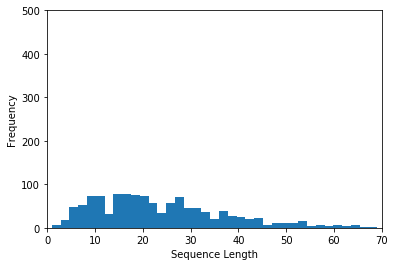

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
def histograma(numWords):
    plt.hist(numWords, 50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.axis([0, 70, 0, 500])
    plt.show()
histograma(numWords)

Converting each sentence into a vector and adding it into a matrix of 'ids'

In [54]:
def integerSenteces(sent,maximum):
    i = 0
    embbeding = 0
    matrix = np.zeros((len(sent), maximum)) #250 X 6 (numEjem X Maximun)
    for s in sent:
        vector = np.zeros((maximum), dtype='int32')
        bound = maximum
        if len(s) < maximum:
            bound = len(s)    

        for token in range(0,bound): #No encuentra macu, porque la corta
            if s[token] not in wordsList:
                vector[token] = embbeding # ???
                #print(s[token])
            else:
                vector[token] = (wordsList.index(s[token]))
                embbeding = vector[token]
        matrix[i] = (vector)
        i += 1
    return matrix

In [55]:
X = integerSenteces(c_sent,maxSeqLength) 
#print("Sentences integer representation: ",(X.shape))
#print("Sentences: ",len(c_sent))
#print("Integer format",X[249])
#print("Normal format",c_sent[249])

Split the Data (stratify) into : Train && Test Sets

In [59]:
print("Sentences: ",len(X),"  Labels: ",len(emotion))
X_train, X_test, Y_train, Y_test = train_test_split(X, emotion, test_size=0.20, random_state=random.randrange(50), stratify=emotion)
print("X_train: ",len(X_train),"  Y_train: ",len(Y_train),"  X_test: ",len(X_test),"  Y_test: ",len(Y_test))

Sentences:  1207   Labels:  1207
X_train:  965   Y_train:  965   X_test:  242   Y_test:  242


Converting the Labels into Onehot Vectors

In [60]:
def toLabels(emo):
    classes = 6
    Y = np.zeros((len(emo), classes)) #Num Ejemplos X 6 emociones
    for e in range(0,len(emo)):
        vector = np.zeros((classes))
        vector[(emo[e] % (classes + 1)) - 1] = 1 
        Y[e] = vector
        #print(emo[e],"---",vector)
    return Y
 
Y_train = toLabels(Y_train)
Y_test = toLabels(Y_test)

In [61]:
print("Y_train: ",Y_train.shape," Num Ejem X # clases")
print("X_train: ",X_train.shape," Num Ejem X Maximun Lengh")
print("Y_test: ",Y_test.shape," Num Ejem X # clases")
print("X_test: ",X_test.shape," Num Ejem X Maximun Lengh")

Y_train:  (965, 6)  Num Ejem X # clases
X_train:  (965, 24)  Num Ejem X Maximun Lengh
Y_test:  (242, 6)  Num Ejem X # clases
X_test:  (242, 24)  Num Ejem X Maximun Lengh


RNN Model

In [62]:
batchSize = 50 #Tiene que ser multiplo del NumEjem
lstmUnits = 64
numClasses = 6

Declarando placeholders para los labels (5 emotions) && data imput

In [63]:
import tensorflow as tf
tf.reset_default_graph()
numDimensions = 300 

#labels = tf.placeholder(tf.float32, [batchSize, numClasses])
#input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])
labels = tf.placeholder(tf.float32, [None, numClasses])
input_data = tf.placeholder(tf.int32, [None, maxSeqLength])

Embeddings: Le damos el formato a nuestra data, aún no compilamos nada, solo declaramos

In [64]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

LSTM Model

In [65]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [66]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [67]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [68]:
learning_rate = 0.004
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

C:\Users\danie\Anaconda3\envs\Compositor\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tensorboar

In [69]:
import datetime
def board(sess):
    tf.summary.scalar('Loss', loss)
    tf.summary.scalar('Accuracy', accuracy)
    tf.summary.histogram("Histogrma/hAccu", accuracy)
    merged = tf.summary.merge_all()
    logdir = "board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)
    return merged,writer

Confusion Matrix Plot

In [70]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [71]:
# Initializing the variables
init = tf.global_variables_initializer()
display_step = 100
numEjemplos = 965
iterations = 10

Epoch: 0001 cost= 1.762188447  accuracy= 30.474716817
Optimization Finished!
Accuracy: 0.49586776
Precision:  [0.61788618 0.47058824 0.39285714 0.         0.28205128]
Recall:  [0.85393258 0.45283019 0.25       0.         0.33333333]
F1:  [0.71698113 0.46153846 0.30555556 0.         0.30555556]
Confusion matrix, without normalization
[[76  6  4  0  3]
 [23 24  1  0  5]
 [ 8 13 11  0 12]
 [ 8  0  7  0  8]
 [ 8  8  5  1 11]]
Normalized confusion matrix
[[0.85 0.07 0.04 0.   0.03]
 [0.43 0.45 0.02 0.   0.09]
 [0.18 0.3  0.25 0.   0.27]
 [0.35 0.   0.3  0.   0.35]
 [0.24 0.24 0.15 0.03 0.33]]


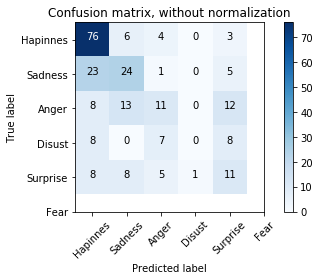

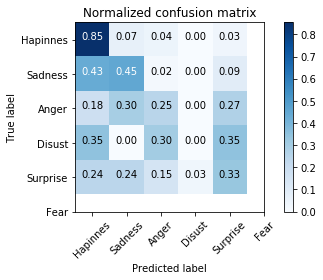

In [72]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    #Calling tensorboard function
    #---merged,writer = board(sess)
    
    # Training cycle
    for epoch in range(iterations):
        avg_cost = 0.
        avg_accu = 0.
        total_batch = int(numEjemplos/batchSize)
        
        #Create X groups of (50,5) Labels && (50,maximum) Examples
        X_batches = np.array_split(X_train, total_batch)
        Y_batches = np.array_split(Y_train, total_batch)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            #print("X: ",batch_x.shape)
            #print("Y: ",batch_y.shape)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c , accu= sess.run([optimizer, loss, accuracy], feed_dict={input_data: batch_x,
                                                          labels: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
            avg_accu += accu / total_batch

            #Write summary to Tensorboard
            '''if (epoch % 10 == 0):
                summary = sess.run(merged, {input_data: batch_x, labels: batch_y})
                writer.add_summary(summary, epoch)'''
            

            #Save the network every 10,000 training iterations
            #if (i % 10000 == 0 and i != 0):
                # save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
                 # print("saved to %s" % save_path)
            #writer.close()

        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)," accuracy=", "{:.9f}".format(avg_accu*100))
    print("Optimization Finished!")
    
    #Test Model LSTM  
    correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correctPred, "float"))
    print("Accuracy:", accuracy.eval({input_data: X_test, labels: Y_test}))
    
    #Matriz de confusion

    #print("Test Samples, Class Predictions: ")
    #----Result es mi tensor prediction convertido a np.array
    result = tf.argmax(prediction , 1).eval({input_data: X_test, labels: Y_test})
    #print(result.shape)
    
    
    #print("Test Samples: ")
    test = (tf.argmax(Y_test , 1).eval()) #Convierte de [0,0,1,0,0] a [2] y lo hace np.array
    #print(test.shape)
    #print("Conversion: ")
    #for i in range(0,len(test)):
        #print(test[i],"---",Y_test[i],"---",result[i])
      

    from sklearn.metrics import confusion_matrix
    y_true = test
    y_pred = result
    #print(confusion_matrix(y_true, y_pred))
    class_names = ["Hapinnes","Sadness","Anger","Disust","Surprise","Fear"]
    
    from sklearn.metrics import precision_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    print("Precision: ",precision_score(y_true, y_pred, average=None))
    print("Recall: ",recall_score(y_true, y_pred, average=None))
    print("F1: ",f1_score(y_true, y_pred, average=None))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()


In [73]:
print(len(emotion)," ",len(sentences))
print(emotion[0]," ",sentences[0])

def writeDataset(emotions,sentences):
    file = open("TaleHetero.txt","w") 
    for i in range(0,len(emotions)):
        linea = str(emotions[i]) + '#' + sentences[i]
        file.write(linea) 
    file.close() 
writeDataset(emotion,sentences)

1207   1207
6   "It is very unpleasant, I am afraid of the police," said Pickles.

